In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim

#set print width to infinity
pd.set_option('display.width', 10000)

In [2]:
mario_data = pd.read_json('mario_file.json')


weight = .8
mario_data['engagement'] = mario_data['attempts']*(weight*mario_data['upload_time']+(1-weight)*mario_data['world_record'])

#drop columns used to construct engagement
mario_data = mario_data.drop(columns=['attempts', 'upload_time', 'world_record'])

#print range of each column
for col in mario_data.columns:
    print(f"{col}: {mario_data[col].min()}, {mario_data[col].max()}")

#log all columns
for col in mario_data.columns:
    mario_data[col] = np.log(mario_data[col]+1)
print()

#print range of each column
for col in mario_data.columns:
    print(f"{col}: {mario_data[col].min()}, {mario_data[col].max()}")

print()
print(mario_data.head())
print(mario_data.columns)

mario_data.dtypes


num_comments: 0, 120515
clears: 0, 1094911
plays: 5, 1701547
likes: 0, 446275
boos: 0, 29632
engagement: 66984.0, 888443714191.0

num_comments: 0.0, 11.69953780318134
clears: 0.0, 13.90618455270647
plays: 1.791759469228055, 14.347048982927777
likes: 0.0, 13.008692873684067
boos: 0.0, 10.296643884176694
engagement: 11.112223992711087, 27.51273713328517

   num_comments    clears     plays     likes      boos  engagement
0      4.110874  7.406711  7.441320  5.030438  4.779123   20.021295
1      0.000000  2.944439  4.158883  1.609438  1.945910   15.407772
2      4.317488  6.206576  6.708084  4.882802  4.820282   18.095203
3      4.110874  7.734559  7.778630  5.686975  3.332205   19.034167
4      3.218876  4.644391  5.983936  3.713572  3.828641   18.698310
Index(['num_comments', 'clears', 'plays', 'likes', 'boos', 'engagement'], dtype='object')


,0
num_comments,float64
clears,float64
plays,float64
likes,float64
boos,float64
engagement,float64


In [3]:
#Module 3 Assignment 19
#Neural Nets

#Define the model network
class MarioNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MarioNet, self).__init__()
        # Fully connected layer 1: input_size -> hidden_size
        self.fc1 = nn.Linear(input_size, hidden_size)
        # ReLU activation function
        self.relu = nn.ReLU()
        # Fully connected layer 2: hidden_size -> output_size
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Pass input through layer 1
        out = self.fc1(x)
        # Apply ReLU activation
        out = self.relu(out)
        # Pass through layer 2 to get to output
        out = self.fc2(out)
        # Apply sigmoid activation to get probabilities
        out = self.sigmoid(out)
        return out

mario_median = mario_data['engagement'].median()
mario_data['engagement'] = np.where(mario_data['engagement'] > mario_median, 1, 0)

train_n = int(0.5 * len(mario_data))

#shuffle data
"chatGPT prompt: How do I shuffle the rows of a pandas df?"
shuffled_mario_data = mario_data.sample(frac=1,random_state=169).reset_index(drop=True)

train_data = shuffled_mario_data.iloc[:train_n]
test_data = shuffled_mario_data.iloc[train_n:]

#split data into train, test input and output
train_input = train_data[train_data.columns[:-1].values].to_numpy()
train_output = train_data[train_data.columns[-1]].to_numpy()
test_input = test_data[test_data.columns[:-1].values].to_numpy()
test_output = test_data[test_data.columns[-1]].to_numpy()

#convert to torch tensors
train_inputs_tensor = torch.tensor(train_input, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_output, dtype=torch.float32).view(-1, 1)
test_inputs_tensor = torch.tensor(test_input, dtype=torch.float32)
test_labels_tensor = torch.tensor(test_output, dtype=torch.float32).view(-1, 1)

In [ ]:
#parameters for our dataset
input_size = 5 # 'num_comments', 'clears', 'plays', 'likes', 'boos'
hidden_size = 32 # number of units in my hidden layer 
output_size = 1 #engagement

#these parameters have to do with the iterative process of slow learning that i mentioned in class
#to understand this better see the slides from Erica Rutter
learning_rate = 0.0001 #eta in ER slides
num_epochs = 20000 #how many times are we going to go through the full data set to train
batch_size = train_n #how many data points in each batch - we are going to only have 1 batch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create an instance of the network
model = MarioNet(input_size, hidden_size, output_size)
model.to(device)

# Loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
loss_vector = np.empty(num_epochs, dtype=object)
test_loss = np.empty(num_epochs, dtype=object)

print()
for epoch in range(num_epochs):
    # Forward pass
    train_inputs_tensor = train_inputs_tensor.to(device)
    train_labels_tensor = train_labels_tensor.to(device)
    outputs = model(train_inputs_tensor)
    loss = criterion(outputs,train_labels_tensor)

    # Backward and optimize
    optimizer.zero_grad() # Clear gradients from the previous step
    loss.backward() # Compute gradients
    optimizer.step() # Update weights

    loss_vector[epoch] = loss.item()

    test_inputs_tensor = test_inputs_tensor.to(device)
    test_labels_tensor = test_labels_tensor.to(device)
    loss_test = criterion(model(test_inputs_tensor), test_labels_tensor)
    test_loss[epoch] = loss_test.item()
    print (f'\rEpoch [{epoch+1}/{num_epochs}], Loss: {loss_test.item():.3f}',end='')


Epoch [20000/20000], Loss: 0.588

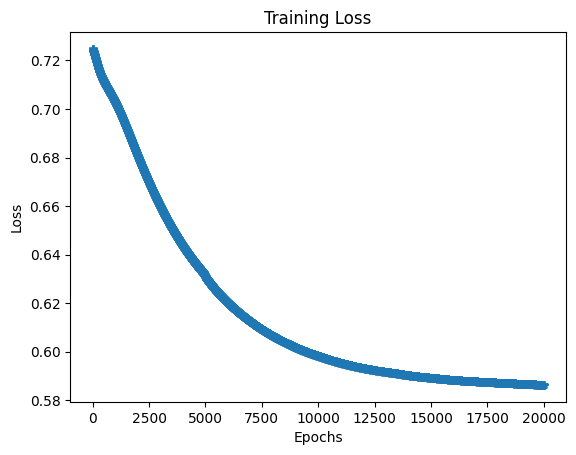

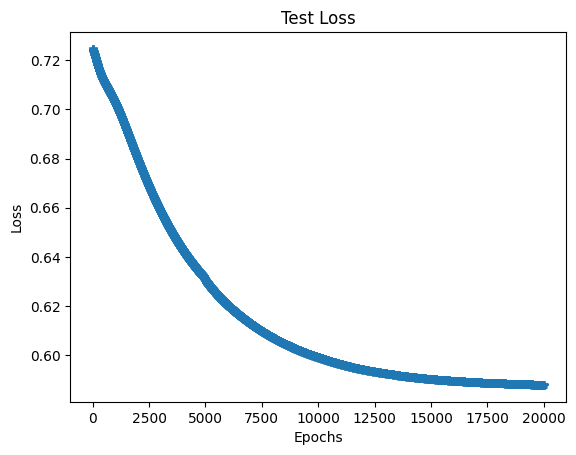

Prediction on Training Data
      num_comments    clears     plays     likes      boos  engagement  is_popular prediction
0         0.693147  2.302585  3.850148  0.693147  1.791759           1                    0.0
1         0.000000  1.609438  4.382027  1.386294  2.079442           1                    1.0
2         1.945910  4.043051  4.543295  2.197225  2.639057           1                    0.0
3         2.302585  6.152733  6.315358  6.098074  6.267201           1                    1.0
4         1.791759  2.639057  3.806662  1.098612  0.693147           0                    0.0
...            ...       ...       ...       ...       ...         ...                    ...
9995      0.693147  1.609438  3.465736  1.098612  1.609438           1                    0.0
9996      0.000000  3.178054  5.225747  2.302585  1.791759           1                    1.0
9997      1.791759  4.174387  4.844187  2.079442  2.079442           0                    0.0
9998      1.609438  3.218876  4.

In [5]:
fig, (ax4) = plt.subplots(1, 1)
plt.plot(loss_vector,'*')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

plt.plot(test_loss,'*')
plt.title('Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Make predictions first on training data (remember to apply sigmoid)
with torch.no_grad():
    train_inputs_tensor = train_inputs_tensor.to(device)
    predicted = model(train_inputs_tensor)
    predicted_classes = (predicted > 0.5).float()
    popularity_pred = predicted_classes.squeeze().cpu().numpy()

    #making a table
    train_pred = train_data.copy()
    train_pred['is_popular prediction'] = popularity_pred
    print('Prediction on Training Data')
    print(train_pred)

    #Classification Error
    train_error = int(np.sum(np.absolute(train_output - popularity_pred)))
    train_error_prop = train_error/train_n
    print(f'Training Error: {train_error}/{train_n}  | Testing Accuracy: {100*(1-train_error_prop):.2f}')

# Make predictions on test data (remember to apply sigmoid)
with torch.no_grad():
    test_inputs_tensor = test_inputs_tensor.to(device)
    predicted = model(test_inputs_tensor)
    predicted_classes = (predicted > 0.5).float()
    popularity_pred = predicted_classes.squeeze().cpu().numpy()

    #making a table
    test_pred = test_data.copy()
    test_pred['is_popular prediction'] = popularity_pred
    print('Prediction on Testing Data')
    print(test_pred)

    #Classification Error
    test_error = int(np.sum(np.absolute(test_output - popularity_pred)))
    test_error_prop = test_error/len(test_data)
    print(f'Testing Error: {test_error}/{len(test_data)}  | Testing Accuracy: {100*(1-test_error_prop):.2f}')

#Reference: ISLP Chapter 10
#Reference to Python torch library being used: https://pytorch.org/tutorials/beginner/basics/intro.html
#Googled and used Google AI overview: simple neural network using pytorch
#Googled and used Google AI overview: simple neural network using pytorch and bcewithlogitsloss
#What loss function to use: https://discuss.pytorch.org/t/bce-loss-vs-cross-entropy/97437/5 and https://sebastianraschka.com/blog/2022/losses-learned-part1.html
#Slides from Erica Rutter: IntroMLCNNRNN_2024 start at slide 10

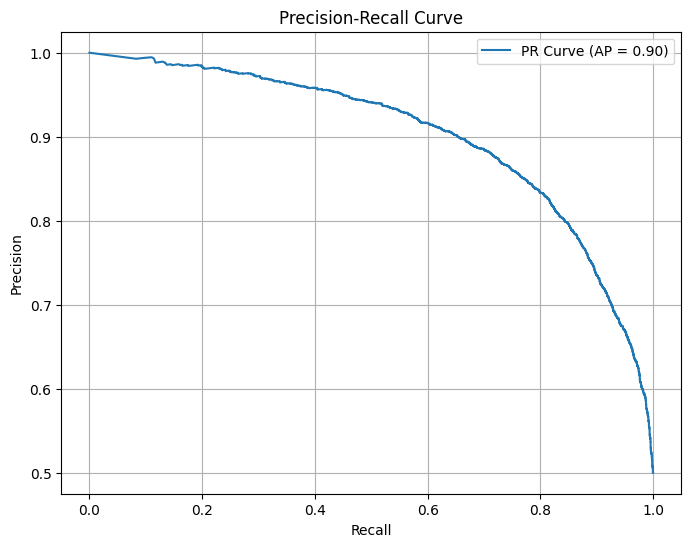

In [8]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
with torch.no_grad():
    test_inputs_tensor = test_inputs_tensor.to(device)
    predicted = model(test_inputs_tensor)
    predicted_probs = predicted.squeeze().cpu().numpy()  # Raw probabilities

    precision, recall, thresholds = precision_recall_curve(test_output, predicted_probs)
    average_precision = average_precision_score(test_output, predicted_probs)

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label=f'PR Curve (AP = {average_precision:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

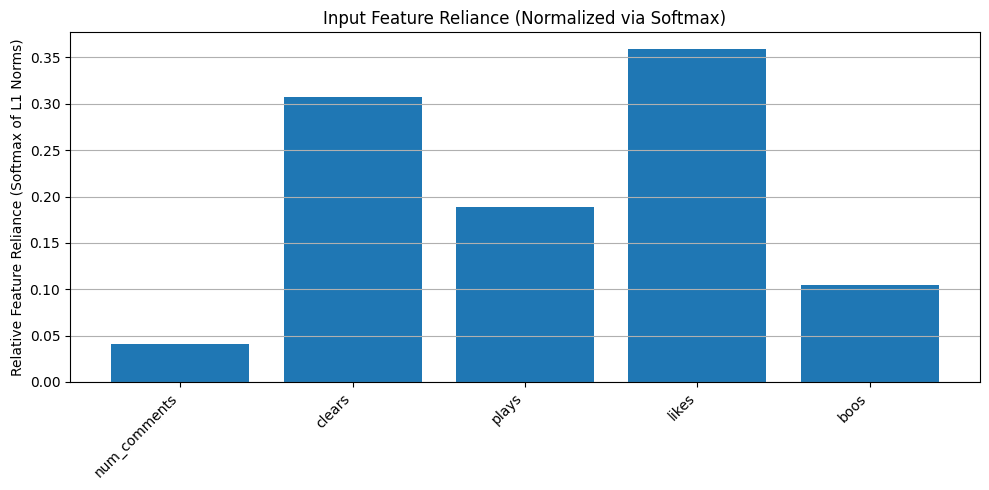

In [20]:
from scipy.special import softmax

first_layer_weights = model.fc1.weight.detach().cpu().numpy()
layer_1_strength = np.linalg.norm(first_layer_weights,axis=0,ord=2)
feature_reliance = softmax(layer_1_strength)

feature_names = mario_data.columns[:-1].values

plt.figure(figsize=(10, 5))
plt.bar(feature_names, feature_reliance)
plt.ylabel("Relative Feature Reliance (Softmax of L1 Norms)")
plt.title("Input Feature Reliance (Normalized via Softmax)")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

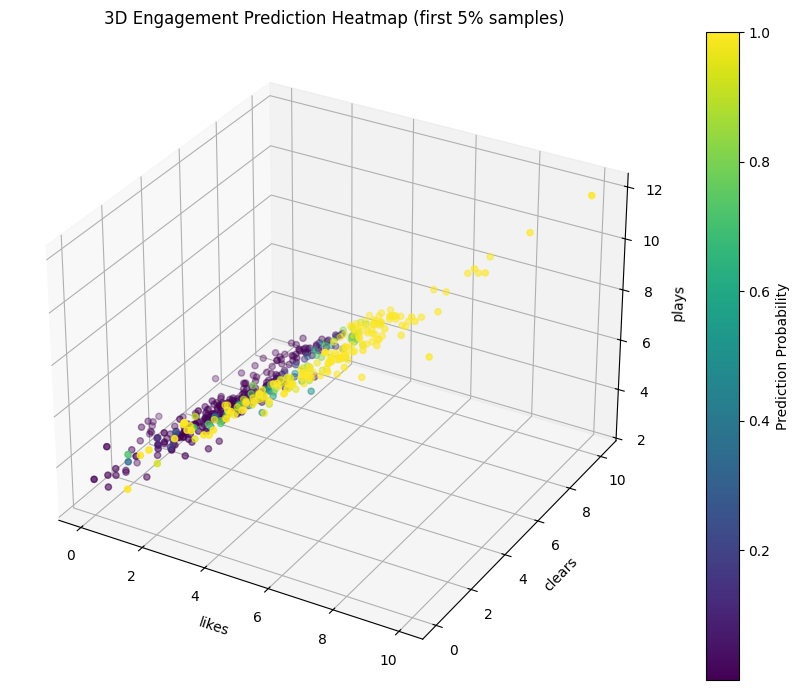

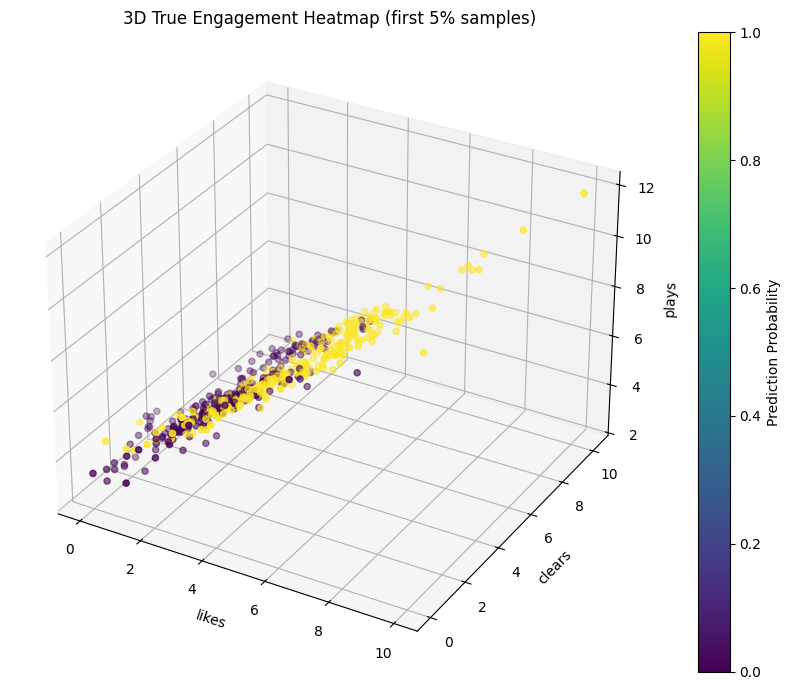

In [32]:
x_feat = 'likes'
y_feat = 'clears'
z_feat = 'plays'

n=512
heat_plot = test_pred.iloc[0:n]

x = heat_plot[x_feat]
y = heat_plot[y_feat]
z = heat_plot[z_feat]
with torch.no_grad():
    predictions = model(test_inputs_tensor).squeeze().cpu().numpy()[:n]

# 3D scatter with color-coded prediction heatmap
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot, color by prediction value
scatter = ax.scatter(x, y, z, c=predictions, cmap='viridis', s=20)
fig.colorbar(scatter, ax=ax, label='Prediction Probability')

ax.set_xlabel(x_feat)
ax.set_ylabel(y_feat)
ax.set_zlabel(z_feat)
ax.set_title(f'3D Engagement Prediction Heatmap (first {100*n/len(test_pred):.0f}% samples)')

plt.tight_layout()
plt.show()

true_engagement = heat_plot['engagement']

# 3D scatter with color-coded prediction heatmap
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot, color by prediction value
scatter = ax.scatter(x, y, z, c=true_engagement, cmap='viridis', s=20)
fig.colorbar(scatter, ax=ax, label='Prediction Probability')

ax.set_xlabel(x_feat)
ax.set_ylabel(y_feat)
ax.set_zlabel(z_feat)
ax.set_title(f'3D True Engagement Heatmap (first {100*n/len(test_pred):.0f}% samples)')

plt.tight_layout()
plt.show()